In [144]:
#####ベイジアンロジスティック回帰モデル#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
from numpy.random import *
from scipy import optimize
from scipy.stats import norm


In [180]:
####データの発生####
#np.random.seed(7643)   #シードを設定
k = 11   #パラメータ数
N = 5000   #サンプル数

##説明変数の発生
#連続変数の発生
cont = 5
X_cont = randn(N, 5)

#二値変数の発生
bin = 3
X_bin = np.zeros((N, bin))

for j in range(X_bin.shape[1]):
    par = uniform(0.3, 0.5, 1)
    X_bin[:, j] = binomial(1, par, N)
    
#多値変数の発生
multi = 4
par = np.array((0.2, 0.2, 0.3, 0.3))
X_multi0 = multinomial(1, par, N)
multi_sum = np.sum(X_multi0, axis=0)
X_multi = np.delete(X_multi0, multi_sum.argmin(), axis=1)   #冗長な変数の削除

#説明変数の結合
intercept = np.ones((N, 1))
X = np.concatenate((intercept, X_cont, X_bin, X_multi), axis=1)
k = X.shape[1]

In [181]:
##応答変数の発生
#パラメータの設定
beta01 = uniform(-0.7, 0.5, 1)
beta02 = uniform(0, 0.7, cont)
beta03 = uniform(-0.9, 1.0, bin)
beta04 = uniform(-0.8, 1.0, multi-1)
beta0 = np.concatenate((beta01, beta02, beta03, beta04), axis=0)   #パラメータを結合

#ロジットと確率を定義
logit = np.dot(X, beta0)
Pr = np.exp(logit) / (1+np.exp(logit))

#ベルヌーイ分布より応答変数を生成
y = binomial(1, Pr, N)
np.mean(y)

0.50519999999999998

In [243]:
####マルコフ連鎖モンテカルロ法でベイジアンロジスティック回帰モデルを推定####
##ロジスティック回帰モデルをの対数尤度関数を設定
def define_likelihood(beta, y, X):
    #ロジットと確率の定義
    logit = np.dot(X, beta)
    Pr = np.exp(logit)/(1+np.exp(logit))
    
    #対数尤度の計算
    LLi = y * np.log(Pr) + (1-y) * np.log(1-Pr)
    LL = sum(LLi)   
    return LL

##多変量正規分布の密度関数
def dmv(x, mu, Cov, k):
    er = x - mu
    Cov_inv = np.linalg.inv(Cov) 
    LLo = 1 / (np.sqrt(pow((2 * np.pi), k) * np.linalg.det(Cov))) * np.exp(np.dot(np.dot(-er, Cov_inv), er) / 2)
    return(LLo)

In [244]:
##アルゴリズムの設定
R = 12000   #サンプリング回数
keep = 4   #4回に1回の割合でサンプリング結果を保存
sbeta = 1.5
BETA = np.zeros((int(R/keep), k))
ALPHA = np.zeros((int(R/keep)))
LL = np.zeros((int(R/keep)))

##事前分布の設定
betas0 = np.zeros((k))
tau0 = np.diag(np.ones((k))) * 100
rw = np.diag(np.ones((k))) * 0.001
mu = np.zeros((k))

##初期値の設定
beta = np.zeros((k))

In [245]:
####メトロポリスヘイスティング法でパラメータをサンプリング####
for rp in range(R):

    ##パラメータをサンプリング
    #betaをサンプリング
    betad = beta
    betan = betad + np.random.multivariate_normal(mu, rw)

    #対数尤度と対数事前分布を計算
    lognew = define_likelihood(betan, y, X)
    logold = define_likelihood(betad, y, X)
    logpnew = np.log(dmv(betan, mu, tau0, k))
    logpold = np.log(dmv(betad, mu, tau0, k))

    #MHサンプリングでbetaを採択するかどうかを決定
    alpha = min(1, np.exp(lognew + logpnew - logold - logpold))
    u = uniform(0, 1, 1)

    #alpha > u なら新しいbetaを採択
    if alpha > u:
        beta = betan
        logl = lognew
    else :
        beta = betad
        logl = logold

    ##サンプリング結果の保存
    if rp%keep==0:
        mkeep = int(rp/keep)
        BETA[mkeep, :] = beta
        ALPHA[mkeep] = alpha
        LL[mkeep] = logl
        print(rp)

0
4
8
12
16
20
24
28
32
36
40
44
48
52
56
60
64
68
72
76
80
84
88
92
96
100
104
108
112
116
120
124
128
132
136
140
144
148
152
156
160
164
168
172
176
180
184
188
192
196
200
204
208
212
216
220
224
228
232
236
240
244
248
252
256
260
264
268
272
276
280
284
288
292
296
300
304
308
312
316
320
324
328
332
336
340
344
348
352
356
360
364
368
372
376
380
384
388
392
396
400
404
408
412
416
420
424
428
432
436
440
444
448
452
456
460
464
468
472
476
480
484
488
492
496
500
504
508
512
516
520
524
528
532
536
540
544
548
552
556
560
564
568
572
576
580
584
588
592
596
600
604
608
612
616
620
624
628
632
636
640
644
648
652
656
660
664
668
672
676
680
684
688
692
696
700
704
708
712
716
720
724
728
732
736
740
744
748
752
756
760
764
768
772
776
780
784
788
792
796
800
804
808
812
816
820
824
828
832
836
840
844
848
852
856
860
864
868
872
876
880
884
888
892
896
900
904
908
912
916
920
924
928
932
936
940
944
948
952
956
960
964
968
972
976
980
984
988
992
996
1000
1004
1008
1012
1016
102

6800
6804
6808
6812
6816
6820
6824
6828
6832
6836
6840
6844
6848
6852
6856
6860
6864
6868
6872
6876
6880
6884
6888
6892
6896
6900
6904
6908
6912
6916
6920
6924
6928
6932
6936
6940
6944
6948
6952
6956
6960
6964
6968
6972
6976
6980
6984
6988
6992
6996
7000
7004
7008
7012
7016
7020
7024
7028
7032
7036
7040
7044
7048
7052
7056
7060
7064
7068
7072
7076
7080
7084
7088
7092
7096
7100
7104
7108
7112
7116
7120
7124
7128
7132
7136
7140
7144
7148
7152
7156
7160
7164
7168
7172
7176
7180
7184
7188
7192
7196
7200
7204
7208
7212
7216
7220
7224
7228
7232
7236
7240
7244
7248
7252
7256
7260
7264
7268
7272
7276
7280
7284
7288
7292
7296
7300
7304
7308
7312
7316
7320
7324
7328
7332
7336
7340
7344
7348
7352
7356
7360
7364
7368
7372
7376
7380
7384
7388
7392
7396
7400
7404
7408
7412
7416
7420
7424
7428
7432
7436
7440
7444
7448
7452
7456
7460
7464
7468
7472
7476
7480
7484
7488
7492
7496
7500
7504
7508
7512
7516
7520
7524
7528
7532
7536
7540
7544
7548
7552
7556
7560
7564
7568
7572
7576
7580
7584
7588
7592
7596


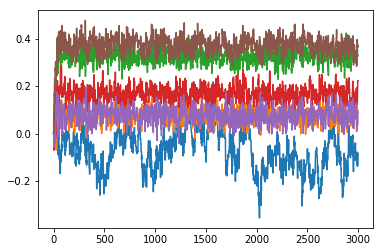

In [253]:
####サンプリング結果の要約と可視化####
burnin = int(1000/keep)
RS = int(R/keep)

##サンプリング結果の可視化
plt.plot(range(BETA.shape[0]), BETA[:, 0:6])
plt.show()

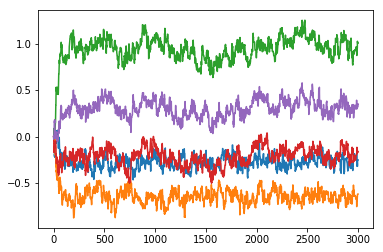

In [252]:
plt.plot(range(BETA.shape[0]), BETA[:, 7:BETA.shape[1]])
plt.show()

In [271]:
##サンプリング結果の要約
np.round(np.array((np.mean(BETA[burnin:RS, :], axis=0), beta0)), 3)   #パラメータの事後平均
np.round(np.std(BETA[burnin:RS, :], axis=0), 3)   #事後標準偏差

array([ 0.086,  0.031,  0.03 ,  0.031,  0.032,  0.032,  0.061,  0.065,
        0.068,  0.106,  0.095,  0.093])

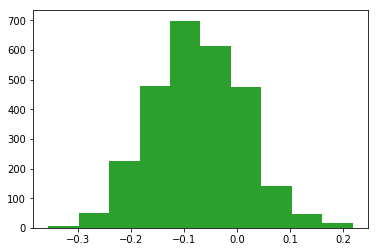

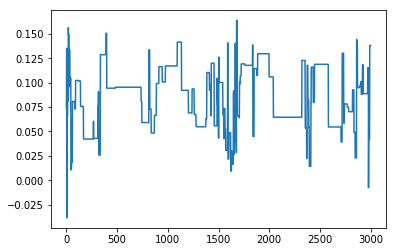

array([   0,    1,    2, ..., 2997, 2998, 2999])